# **Crypto market capitalization forecast based on S&P 500.**

## **Abstract**
   Abstract here. Give an executive summary of your project: goal, methods, results, conclusions. Usually no more than 200 words.


## **Introduction**

Here you have to explain the problem that you are solving. Explain why it is important, and what are the main challenges. Mention previous attempts (add papers as references) to solve it. Mainly focus on the techniques closely related to our approach. Briefly describe your approach and explain why it is promising for solving the addressed problem. Mention the dataset and the main results achieved.

In this section, you can add **text** and **figures**.

## **Methodology**
Describe the important steps you took to achieve your goal. Focus more on the most important steps (preprocessing, extra features, model aspects) that turned out to be important. Mention the original aspects of the project and state how they relate to existing work.

In this section, you can add **text** and **figures**. For instance, it is strongly suggested to add a picture of the best machine learning model that you implemented to solve your problem (and describe it).


### **Preprocessing**

The first step in our methodology involved preprocessing the raw data from 2 sources: Kaggle and CoinCodex. We will be using the Kaggle data for everything that is related to the S&P500, and CoinCodex for everything related crypto. For the cryptocurrency data, we focused on key features such as Date, Volume, and Marketcap. Similarly, for the S&P500 data, we retained relevant columns like Date, Open, High, Low, Close, Volume, and additional info regarding the fear index (VIX). The datasets were cleaned to handle missing values, if any, unwanted data and the Date columns were standardized to ensure compatibility for merging.

First Let's import the necessary libraries that we need for the project and define some constants!
Run the code below...


In [1]:
import os
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
DATA_PATH = 'Data/'
STOCK_DATA_PATH_RAW = 'Data/StockData/RawData/'
STOCK_DATA_PATH_PROCESSED = 'Data/StockData/preProcessedData/'
CRYPTO_DATA_PATH_RAW = 'Data/CryptoData/RawData/'
CRYPTO_DATA_PATH_PROCESSED = 'Data/CryptoData/PreProcessedData/'
KAGGLE_DATA_PATH = 'Data/KaggleData/'
START_DATE = '2018-01-18'
END_DATE = '2025-04-04'

Once the libraries imported, we can now load the S&P500 data, and an example of crypto data to take a look at the first few rows along with some additional info by running the code below.

In [3]:
def load_data(filename: str, date_col: str, date_format: str) -> pd.DataFrame:
    """
    Loads a CSV file into a pandas DataFrame and parses the date column.

    Args:
        filename (str): Name of the CSV file.
        date_col (str): Name of the date column.
        date_format (str): Format of the date in the CSV.

    Returns:
        pd.DataFrame: Processed DataFrame with parsed dates.
    """
    filepath = os.path.join(STOCK_DATA_PATH_RAW, filename)
    df = pd.read_csv(filepath)
    df[date_col] = pd.to_datetime(df[date_col], format=date_format)
    return df

stock_df = load_data('S&P500_Historical_Data.csv', 'Date', '%Y-%m-%d')
vix_df = load_data('VIX_Historical_Data.csv', 'Date', '%m/%d/%Y')

for name, df in zip(["Stock", "VIX"], [stock_df, vix_df]):
    print(f"\n{name} Dataset ==> Min Date: {df['Date'].min()} / Max Date: {df['Date'].max()}")



Stock Dataset ==> Min Date: 2017-01-03 00:00:00 / Max Date: 2025-04-04 00:00:00

VIX Dataset ==> Min Date: 1990-01-02 00:00:00 / Max Date: 2025-04-04 00:00:00


In [4]:
stock_df.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,2025-04-04,"5,074.08","5,292.14","5,292.14","5,069.90",NaN,-5.97%
1,2025-04-03,"5,396.52","5,492.74","5,499.53","5,390.83",NaN,-4.84%
2,2025-04-02,"5,670.97","5,580.76","5,695.31","5,571.48",NaN,0.67%
3,2025-04-01,"5,633.07","5,597.53","5,650.57","5,558.52",NaN,0.38%
4,2025-03-31,"5,611.85","5,527.91","5,627.56","5,488.73",NaN,0.55%


In [5]:
vix_df.head()

,Date,Open,High,Low,Close
0,1990-01-02,17.24,17.24,17.24,17.24
1,1990-01-03,18.19,18.19,18.19,18.19
2,1990-01-04,19.22,19.22,19.22,19.22
3,1990-01-05,20.11,20.11,20.11,20.11
4,1990-01-08,20.26,20.26,20.26,20.26


In [6]:
btc_df = pd.read_csv(os.path.join(CRYPTO_DATA_PATH_RAW, 'BTC.csv'))
btc_df.head()

,Start,End,Open,High,Low,Close,Volume,Market Cap
0,2025-04-06,2025-04-07,83533.45,83704.76,77296.39,78310.34,2.974769e+10,1.626852e+12
1,2025-04-05,2025-04-06,83769.12,84219.70,82384.97,83582.03,5.424886e+10,1.654110e+12
2,2025-04-04,2025-04-05,83259.08,84676.27,81767.53,83879.86,6.263226e+10,1.654911e+12
3,2025-04-03,2025-04-04,82259.03,83781.70,81307.75,83199.95,7.766843e+10,1.643472e+12
4,2025-04-02,2025-04-03,85170.68,87898.01,82487.40,82548.31,5.237611e+10,1.688190e+12


#### **Crypto Data**

Great, let's now tackle our raw crypto data.  
After some research and many hours of trying to find the best balance between variety of cryptos and the amount of data that can be used, I have decided to include 14 cryptos from the top 100 where the data stretches from 2018 to 2025.  

Let us take a look at an example of crypto data that we have:

**Note**: We have a CSV for every crypto. (14 CSVs total)

Let us standardize our timeframe now. From all the CSVs we have, we can see that our range should be from 2018-1-18 to 2025-04-04 to match the maximum date of the stock market data and the minimum date of the crypto CSVs.

In [7]:
date_range = pd.date_range(start=START_DATE, end=END_DATE, freq='D')
processed_dfs = {}  # Dictionary to store processed DataFrames (key: symbol, value: DataFrame)

for filename in os.listdir(CRYPTO_DATA_PATH_RAW):
    try:
        raw_path = os.path.join(CRYPTO_DATA_PATH_RAW, filename)
        df = pd.read_csv(raw_path)
        df['Start'] = pd.to_datetime(df['Start'])
        df = df[df['Start'].isin(date_range)]
        df = df.sort_values('Start')
        
        symbol = filename.split('.')[0]  # Extract symbol (e.g., 'BTC' from 'BTC.csv')
        processed_dfs[symbol] = df # Store processed DataFrame in the dictionary
        
    except Exception as e:
        print(f"Error processing {filename}: {str(e)}")

print("All files processed!")

All files processed!


Let us now check for some missing values in the most interesting features!

In [8]:
# Check for missing/invalid values (0, -1, or NaN) in key columns
for symbol, df in processed_dfs.items():
    invalid_volume = ((df['Volume'] == 0) | (df['Volume'] == -1) | (df['Volume'].isna())).sum()
    invalid_market_cap = ((df['Market Cap'] == 0) | (df['Market Cap'] == -1) | (df['Market Cap'].isna())).sum()
    
    if invalid_volume > 0 or invalid_market_cap > 0:
        print(f"\n{symbol}:")
        print(f"  ==> Missing/Invalid 'Volume' values: {invalid_volume}")
        print(f"  ==> Missing/Invalid 'Market Cap' values: {invalid_market_cap}")

print("\nCheck complete!")


BNB:
  ==> Missing/Invalid 'Volume' values: 0
  ==> Missing/Invalid 'Market Cap' values: 133

EOS:
  ==> Missing/Invalid 'Volume' values: 0
  ==> Missing/Invalid 'Market Cap' values: 133

Check complete!


After inspecting the dataframes of each token, we can see that there are some data points of market cap data missing in BNB and EOS.  
We will use data from kaggle to fill that in.  

In [9]:
def update_market_caps(processed_dfs, all_crypto_file):
    all_crypto_df = pd.read_csv(all_crypto_file)
    
    for symbol, crypto_df in processed_dfs.items():
        try:
            crypto_df['Start'] = pd.to_datetime(crypto_df['Start'])
            symbol_data = all_crypto_df[all_crypto_df['Symbol'] == symbol].copy()
            symbol_data['Date'] = pd.to_datetime(symbol_data['Date'], format='%d-%m-%Y %H:%M')
            
            # Normalize dates for comparison
            crypto_df['Start_date'] = crypto_df['Start'].dt.normalize()
            symbol_data['Date_date'] = symbol_data['Date'].dt.normalize()
            
            # Map market caps by date
            market_cap_dict = dict(zip(symbol_data['Date_date'], symbol_data['Marketcap']))
            
            # Update missing market caps
            updated_count = 0
            for index, row in crypto_df.iterrows():
                if row['Market Cap'] in [0.0, -1.0]:
                    start_date = row['Start_date']
                    if start_date in market_cap_dict:
                        crypto_df.at[index, 'Market Cap'] = market_cap_dict[start_date]
                        updated_count += 1
            
            crypto_df.drop(columns=['Start_date'], inplace=True)
            
            if updated_count > 0:
                print(f"{symbol}: Updated {updated_count} market cap values")
                
        except Exception as e:
            print(f"Error processing {symbol}: {str(e)}")

update_market_caps(processed_dfs, KAGGLE_DATA_PATH + 'All_Crypto.csv')
print("\nMarket caps updated!")

BNB: Updated 133 market cap values
EOS: Updated 133 market cap values

Market caps updated!


Nice, now our crypto data is complete within the time range of 2018 to 2025.  
Let us now work on dropping the unwated features and making the merged crypto dataset.

In [10]:
# Merge all DataFrames and add 'symbol' column
merged_df = pd.concat(
    [df.assign(symbol=symbol) for symbol, df in processed_dfs.items()],
    ignore_index=True
)

# Drop unwanted columns and rename
merged_df.drop(columns=['End', 'Low', 'High', 'Open', 'Close'], inplace=True)
merged_df.rename(columns={'Start': 'Date', 'Market Cap': 'MarketCap'}, inplace=True)

# Save the final merged file
output_file = 'Crypto.csv'
merged_df.to_csv(os.path.join(CRYPTO_DATA_PATH_PROCESSED, output_file), index=False)
print(f"Merged data saved to {output_file}")

Merged data saved to Crypto.csv


Let us now aggregate the data to have the daily total Market Cap and Voume.

In [11]:
# Aggregate the data by date so that each date has the sum of market caps and volumes for all cryptocurrencies
def aggregate_crypto_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    Aggregates crypto data by date, summing 'Volume' and 'MarketCap',
    and renames the columns for clarity.
    
    Args:
        df (pd.DataFrame): The input DataFrame with 'Date', 'Volume', and 'MarketCap' columns.
    
    Returns:
        pd.DataFrame: Aggregated DataFrame with 'Date', 'Crypto_Volume', and 'Crypto_Market_Cap'.
    """
    aggregated_df = (
        df.groupby('Date', as_index=False)
        .agg({'Volume': 'sum', 'MarketCap': 'sum'})
        .rename(columns={'Volume': 'Crypto_Volume', 'MarketCap': 'Crypto_Market_Cap'})
    )

    return aggregated_df

In [12]:
crypto_df = aggregate_crypto_data(merged_df)
crypto_df.to_csv(os.path.join(CRYPTO_DATA_PATH_PROCESSED, 'Aggregated_Crypto.csv'), index=False)
print("Aggregated data saved to Aggregated_Crypto.csv")

Aggregated data saved to Aggregated_Crypto.csv


#### **S&P500 Data**

Let us now process the stock market data.  
We need to keep in mind that the stock market closes on the weekends. Thus, for the sake of this project, we will assume that the last available price (Friday’s) carries over to Saturday and Sunday since stock prices don’t change on weekends.  
We will use Forward fill to accomplish this.  
This will keep the dataset aligned with the crypto data. Also, it reflects the reality that stock prices remain unchanged on weekends.
Same thing will be done to the VIX data frame as well.

Let's define some helper functions...

In [13]:
def handle_closed_weekends(df: pd.DataFrame, start_date: str, end_date: str, date_col: str = 'Date') -> pd.DataFrame:
    """
    Processes S&P 500 data to:
    1. Filter date range
    2. Expand to include weekends
    3. Forward-fill price columns
    4. Set 'Change_%' to 0.0 on weekends
    5. Ensure proper datetime format
    
    Args:
        df: DataFrame with market data
        start_date: Start date (YYYY-MM-DD)
        end_date: End date (YYYY-MM-DD)
        date_col: Name of date column
    
    Returns:
        Processed DataFrame with continuous daily data
    """
    df[date_col] = pd.to_datetime(df[date_col])
    filtered_df = df[(df[date_col] >= start_date) & (df[date_col] <= end_date)].copy()
    
    full_dates = pd.date_range(start=start_date, end=end_date, freq='D')
    
    if 'S&P500_Change_%' in filtered_df.columns:
        filtered_df['S&P500_Change_%'] = (
            filtered_df['S&P500_Change_%']
            .astype(str)
            .str.replace('%', '')
            .replace('', '0')
            .astype(float)
        )
    
    reindexed_df = (
        filtered_df
        .set_index(date_col)
        .reindex(full_dates)
    )
    
    price_cols = [col for col in reindexed_df.columns if col != 'Change_%']
    
    reindexed_df[price_cols] = reindexed_df[price_cols].ffill()
    
    if 'S&P500_Change_%' in reindexed_df.columns:
        reindexed_df['S&P500_Change_%'] = reindexed_df['S&P500_Change_%'].fillna(0.0)
    
    result = reindexed_df.reset_index().rename(columns={'index': date_col})
    
    result[date_col] = pd.to_datetime(result[date_col])
    
    return result

def preprocess_sp500(df: pd.DataFrame, start_date: str, end_date: str) -> pd.DataFrame:
    df = df.drop(columns=['Vol.'], errors='ignore')
    df['Open'] = df['Open'].str.replace(',', '').astype(float)
    df['High'] = df['High'].str.replace(',', '').astype(float)
    df['Low'] = df['Low'].str.replace(',', '').astype(float)
    df['Price'] = df['Price'].str.replace(',', '').astype(float)
    df = df.rename(columns={
            'Open': 'S&P500_Open',
            'High': 'S&P500_High',
            'Low': 'S&P500_Low',
            'Price': 'S&P500_Close',
            'Change %': 'S&P500_Change_%'
    })
    
    if not pd.api.types.is_datetime64_any_dtype(df['Date']):
        df['Date'] = pd.to_datetime(df['Date'])
    
    processed = handle_closed_weekends(
        df=df,
        start_date=start_date,
        end_date=end_date,
        date_col='Date'
    )
    
    return processed

def preprocess_vix(df: pd.DataFrame, start_date: str, end_date: str) -> pd.DataFrame:
    df['Date'] = pd.to_datetime(df['Date']).dt.strftime('%Y-%m-%d')
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.rename(columns={
            'Open': 'VIX_Open',
            'High': 'VIX_High',
            'Low': 'VIX_Low',
            'Close': 'VIX_Close'
        })
    
    date_range = pd.date_range(start=start_date, end=end_date, freq='D')
    df = (
        df.set_index('Date')
        .reindex(date_range)
        .ffill()
        .reset_index()
        .rename(columns={'index': 'Date'})
    )
    
    return df

In [14]:
# Process both datasets
stock_df = preprocess_sp500(stock_df, START_DATE, END_DATE)
vix_df = preprocess_vix(vix_df, START_DATE, END_DATE)

# Print results
print(f"S&P500 dataset: {stock_df['Date'].min()} to {stock_df['Date'].max()} "
      f"with {len(stock_df)} rows")
print(f"Columns: {stock_df.columns.tolist()}\n")

print(f"VIX dataset: {vix_df['Date'].min()} to {vix_df['Date'].max()} "
      f"with {len(vix_df)} rows")
print(f"Columns: {vix_df.columns.tolist()}")

S&P500 dataset: 2018-01-18 00:00:00 to 2025-04-04 00:00:00 with 2634 rows
Columns: ['Date', 'S&P500_Close', 'S&P500_Open', 'S&P500_High', 'S&P500_Low', 'S&P500_Change_%']

VIX dataset: 2018-01-18 00:00:00 to 2025-04-04 00:00:00 with 2634 rows
Columns: ['Date', 'VIX_Open', 'VIX_High', 'VIX_Low', 'VIX_Close']


In [15]:
# Save the processed stock and VIX data
stock_df.to_csv(os.path.join(STOCK_DATA_PATH_PROCESSED, 'S&P500.csv'), index=False)
vix_df.to_csv(os.path.join(STOCK_DATA_PATH_PROCESSED, 'VIX.csv'), index=False)
print("Processed stock and VIX data saved!")

Processed stock and VIX data saved!


#### **Merging and Unification of the datasets**

Perfect, now that we have cleaned the data, we still have to unify our datasets into one before starting to play with models.  

In [16]:
temp_df = pd.merge(stock_df, vix_df, on='Date', how='inner')
main_df = pd.merge(temp_df, crypto_df, on='Date', how='inner')
main_df.to_csv(os.path.join(DATA_PATH, 'MainData.csv'), index=False)
main_df.head()

,Date,S&P500_Close,S&P500_Open,S&P500_High,S&P500_Low,S&P500_Change_%,VIX_Open,VIX_High,VIX_Low,VIX_Close,Crypto_Volume,Crypto_Market_Cap
0,2018-01-18,2798.0,2802.4,2805.8,2792.6,-0.16,12.01,12.40,11.62,12.22,3.397555e+10,4.182316e+11
1,2018-01-19,2810.3,2802.6,2810.3,2798.1,0.44,12.30,12.33,11.18,11.27,2.290271e+10,4.241106e+11
2,2018-01-20,2810.3,2802.6,2810.3,2798.1,0.44,12.30,12.33,11.18,11.27,1.770756e+10,4.568364e+11
3,2018-01-21,2810.3,2802.6,2810.3,2798.1,0.44,12.30,12.33,11.18,11.27,1.591606e+10,4.235859e+11
4,2018-01-22,2833.0,2809.2,2833.0,2808.1,0.81,11.59,11.62,10.84,11.03,1.512720e+10,4.032085e+11


#### **Feature Engineering**

Now that we have our main dataset, we can add meaningful features to it that will probably help with the training of the models.  
Let's define some helper functions.

In [ ]:
# Help model to learn seasonal or cyclic patterns
def add_seasonal_features(df: pd.DataFrame, date_col: str) -> pd.DataFrame:
    """
    Adds seasonal features to the DataFrame based on the date column.
    
    Args:
        df (pd.DataFrame): The input DataFrame.
        date_col (str): The name of the date column.
    
    Returns:
        pd.DataFrame: DataFrame with added seasonal features.
    """
    df['Year'] = df[date_col].dt.year
    df['Month'] = df[date_col].dt.month
    df['Day'] = df[date_col].dt.day
    df['DayOfWeek'] = df[date_col].dt.dayofweek
    df['IsWeekend'] = df['DayOfWeek'] >= 5
    
    return df

# Add rolling statistics
def add_rolling_statistics(df: pd.DataFrame, window: int = 9) -> pd.DataFrame:
    """
    Adds rolling statistics to the DataFrame.
    
    Args:
        df (pd.DataFrame): The input DataFrame.
        window (int): The rolling window size.
    
    Returns:
        pd.DataFrame: DataFrame with added rolling statistics.
    """
    df['SP500_EMA'] = df['S&P500_Close'].ewm(span=window, adjust=False).mean()  
    df['Market_Cap_STD'] = df['Crypto_Market_Cap'].rolling(window=window).std()
    windows = [20, 50, 100, 200] 
    for w in windows:
        df[f'SP500_SMA_{w}'] = df['S&P500_Close'].rolling(window=w).mean()
    return df

# Add lag features
def add_lag_features(df: pd.DataFrame, lag: int = 1) -> pd.DataFrame:
    """
    Adds lag features to the DataFrame.
    
    Args:
        df (pd.DataFrame): The input DataFrame.
        lag (int): The lag period.
    
    Returns:
        pd.DataFrame: DataFrame with added lag features.
    """
    df['Lagged_Market_Cap'] = df['Crypto_Market_Cap'].shift(lag)
    df['Lagged_VIX_Close'] = df['VIX_Close'].shift(lag)
    df['Lagged_S&P500_Close'] = df['S&P500_Close'].shift(lag)
    
    return df

# Add crypto percent change
def add_crypto_percent_change(df: pd.DataFrame) -> pd.DataFrame:
    """
    Adds percentage change for the Crypto_Market_Cap column.
    
    Args:
        df (pd.DataFrame): The input DataFrame.
    
    Returns:
        pd.DataFrame: DataFrame with added percentage change feature.
    """
    df['Crypto_Market_Cap_%'] = df['Crypto_Market_Cap'].pct_change() * 100
    df['Crypto_Volume_Change_%'] = df['Crypto_Volume'].pct_change() * 100

    return df

In [18]:
# Add all features to the DataFrame
main_df = add_seasonal_features(main_df, 'Date')
main_df = add_rolling_statistics(main_df, window=7)
main_df = add_lag_features(main_df, lag=1)
main_df = add_crypto_percent_change(main_df)

# Drop rows with NaN values created by rolling and lag features
main_df.dropna(inplace=True)

main_df.to_csv(os.path.join(DATA_PATH, 'MainData_FeatureEngineering.csv'), index=False)
main_df.head()

,Date,S&P500_Close,S&P500_Open,S&P500_High,S&P500_Low,S&P500_Change_%,VIX_Open,VIX_High,VIX_Low,VIX_Close,...,Day,DayOfWeek,IsWeekend,Market_Cap_MA,Market_Cap_STD,Lagged_Market_Cap,Lagged_VIX_Close,Lagged_S&P500_Close,Crypto_Market_Cap_%,Crypto_Volume_Change_%
6,2018-01-24,2837.5,2845.4,2853.0,2824.8,-0.06,11.00,12.19,10.89,11.47,...,24,2,False,4.128377e+11,2.656393e+10,3.854730e+11,11.10,2839.1,-1.830219,-11.335148
7,2018-01-25,2839.2,2846.2,2848.6,2830.9,0.06,11.27,12.01,11.20,11.58,...,25,3,False,4.121448e+11,2.646285e+10,3.784180e+11,11.47,2837.5,9.239390,3.199358
8,2018-01-26,2872.9,2847.5,2872.9,2846.2,1.19,11.40,11.60,11.08,11.08,...,26,4,False,4.086617e+11,2.622897e+10,4.133815e+11,11.58,2839.2,-3.302721,-9.911246
9,2018-01-27,2872.9,2847.5,2872.9,2846.2,1.19,11.40,11.60,11.08,11.08,...,27,5,True,4.017297e+11,1.565621e+10,3.997286e+11,11.08,2872.9,2.147406,-11.931714
10,2018-01-28,2872.9,2847.5,2872.9,2846.2,1.19,11.40,11.60,11.08,11.08,...,28,6,True,4.028422e+11,1.762148e+10,4.083124e+11,11.08,2872.9,5.647910,-1.195373


#### **Data Analysis**

Now that we have our merged, cleaned, and well structured dataset, let us dive have a small peak about its different features!  
We can understand it more this way.  

In [19]:
main_df.describe().transpose()

,count,mean,min,25%,50%,75%,max,std
Date,2628,2021-08-29 12:00:00,2018-01-24 00:00:00,2019-11-11 18:00:00,2021-08-29 12:00:00,2023-06-17 06:00:00,2025-04-04 00:00:00,NaN
S&P500_Close,2628.0,3933.656168,2237.4,2971.275,3950.665,4505.42,6144.15,976.837172
S&P500_Open,2628.0,3932.932542,2290.7,2968.0,3953.36,4506.4275,6134.5,976.644666
S&P500_High,2628.0,3955.263615,2300.7,2985.675,3974.39,4526.33,6147.43,979.7224
S&P500_Low,2628.0,3908.828862,2191.9,2953.425,3916.995,4483.7,6111.15,973.767101
S&P500_Change_%,2628.0,0.056149,-11.98,-0.48,0.09,0.69,9.38,1.230593
VIX_Open,2628.0,20.055624,10.93,14.8275,18.165,22.96,82.69,7.634397
VIX_High,2628.0,21.24411,11.18,15.45,19.33,24.37,85.47,8.466505
VIX_Low,2628.0,18.883881,10.17,13.99,17.21,21.67,70.37,6.833166
VIX_Close,2628.0,19.794365,10.85,14.65,17.98,22.7125,82.69,7.49645


lets try to take a visual look at our labels (the actual feature that we are trying to predict (first graph)) and other important features!


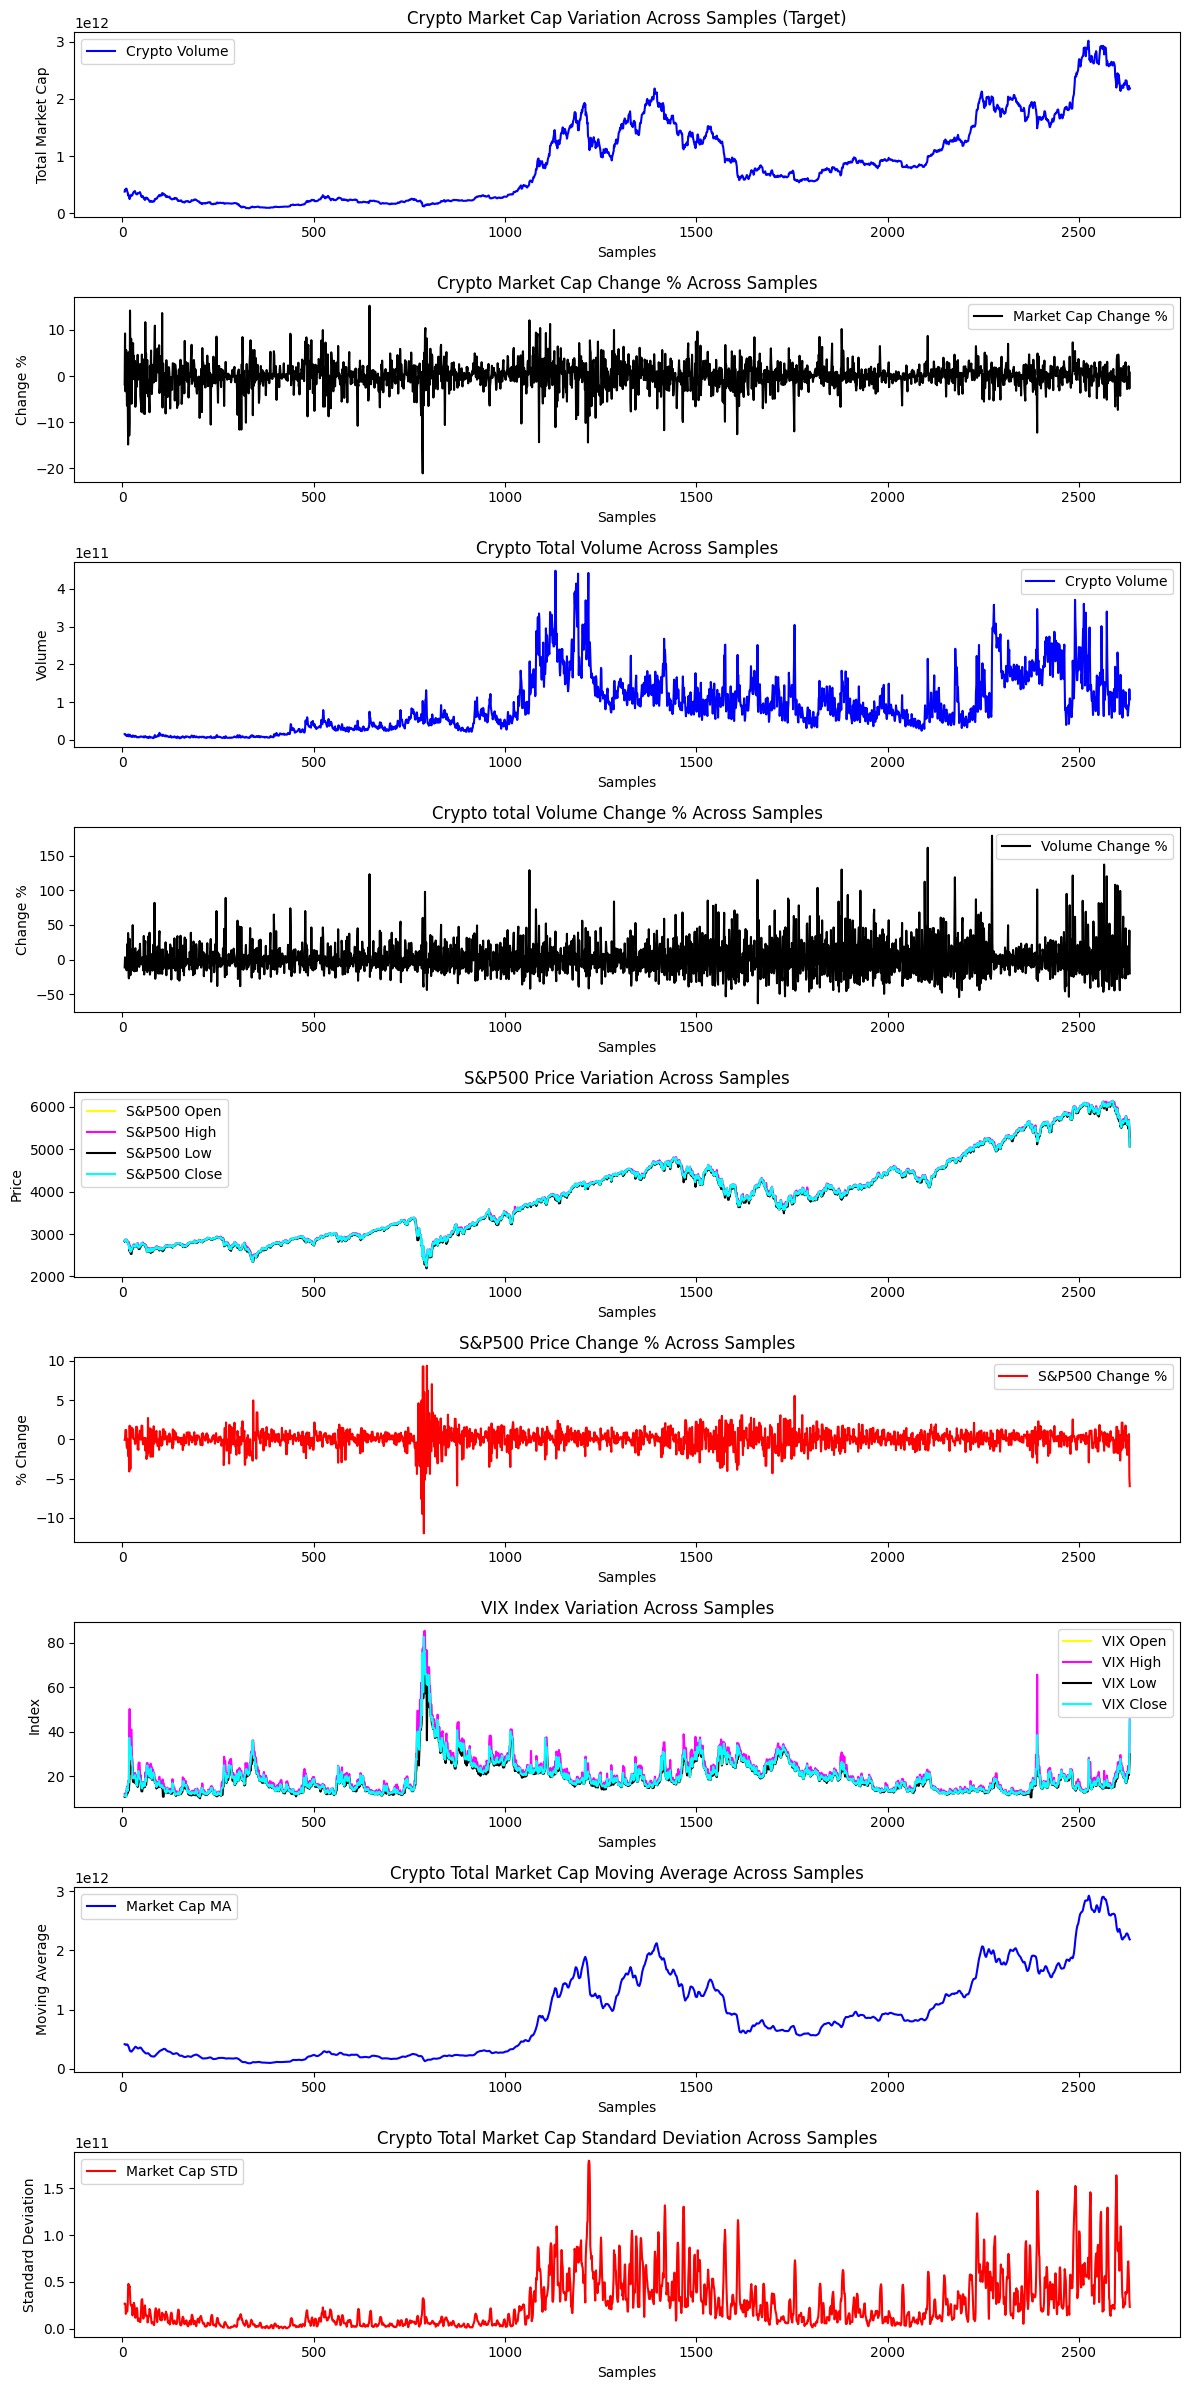

In [34]:
fig, axes = plt.subplots(9, 1, figsize=(12, 24)) 

# First plot: Crypto Total Market Cap (Our Target)
axes[0].plot(main_df.index, main_df['Crypto_Market_Cap'], label='Crypto Volume', color='blue')
axes[0].set_title('Crypto Market Cap Variation Across Samples (Target)')
axes[0].set_xlabel('Samples')
axes[0].set_ylabel('Total Market Cap')
axes[0].legend()

# Second plot: Crypto Total Market % Change
axes[1].plot(main_df.index, main_df['Crypto_Market_Cap_%'], label='Market Cap Change %', color='black')
axes[1].set_title('Crypto Market Cap Change % Across Samples')
axes[1].set_xlabel('Samples')
axes[1].set_ylabel('Change %')
axes[1].legend()

# Third plot: Crypto Total Volume
axes[2].plot(main_df.index, main_df['Crypto_Volume'], label='Crypto Volume', color='blue')
axes[2].set_title('Crypto Total Volume Across Samples')
axes[2].set_xlabel('Samples')
axes[2].set_ylabel('Volume')
axes[2].legend()

# Fourth plot: Crypto Total Volume % Change
axes[3].plot(main_df.index, main_df['Crypto_Volume_Change_%'], label='Volume Change %', color='black')
axes[3].set_title('Crypto total Volume Change % Across Samples')
axes[3].set_xlabel('Samples')
axes[3].set_ylabel('Change %')
axes[3].legend()

# Fifth plot: S&P500 Prices
axes[4].plot(main_df.index, main_df['S&P500_Open'], label='S&P500 Open', color='yellow')
axes[4].plot(main_df.index, main_df['S&P500_High'], label='S&P500 High', color='magenta')
axes[4].plot(main_df.index, main_df['S&P500_Low'], label='S&P500 Low', color='black')
axes[4].plot(main_df.index, main_df['S&P500_Close'], label='S&P500 Close', color='cyan')
axes[4].set_title('S&P500 Price Variation Across Samples')
axes[4].set_xlabel('Samples')
axes[4].set_ylabel('Price')
axes[4].legend()

# Sixth plot: S&P500 % Change
axes[5].plot(main_df.index, main_df['S&P500_Change_%'], label='S&P500 Change %', color='red')
axes[5].set_title('S&P500 Price Change % Across Samples')
axes[5].set_xlabel('Samples')
axes[5].set_ylabel('% Change')
axes[5].legend()

# Seventh plot: VIX Prices
axes[6].plot(main_df.index, main_df['VIX_Open'], label='VIX Open', color='yellow')
axes[6].plot(main_df.index, main_df['VIX_High'], label='VIX High', color='magenta')
axes[6].plot(main_df.index, main_df['VIX_Low'], label='VIX Low', color='black')
axes[6].plot(main_df.index, main_df['VIX_Close'], label='VIX Close', color='cyan')
axes[6].set_title('VIX Index Variation Across Samples')
axes[6].set_xlabel('Samples')
axes[6].set_ylabel('Index')
axes[6].legend()

# Eigth plot: Crypto Total Market Cap Moving Average
axes[7].plot(main_df.index, main_df['Market_Cap_MA'], label='Market Cap MA', color='blue')
axes[7].set_title('Crypto Total Market Cap Moving Average Across Samples')
axes[7].set_xlabel('Samples')
axes[7].set_ylabel('Moving Average')
axes[7].legend()

# Ninth plot: Crypto Total Market Cap Standard Deviation
axes[8].plot(main_df.index, main_df['Market_Cap_STD'], label='Market Cap STD', color='red')
axes[8].set_title('Crypto Total Market Cap Standard Deviation Across Samples')
axes[8].set_xlabel('Samples')
axes[8].set_ylabel('Standard Deviation')
axes[8].legend()

plt.tight_layout()
plt.show()


Additionally, discvering the corelations between variables is also a crucial step. By running the code below, we can see what features are most correlated to out target feature.

**Side note**: Here I decided to use **Spearman correlation** because it is better for predicting crypto market cap changes based on S&P 500. It measures the monotonic relationship between variables rather than assuming a strictly linear one like **Pearson**. Since financial markets often exhibit non-linear dependencies, where crypto and S&P 500 might move in the same general direction but not at a constant rate, Spearman is more robust in capturing such patterns. Additionally, it is less sensitive to outliers, which is crucial in volatile markets like cryptocurrency.

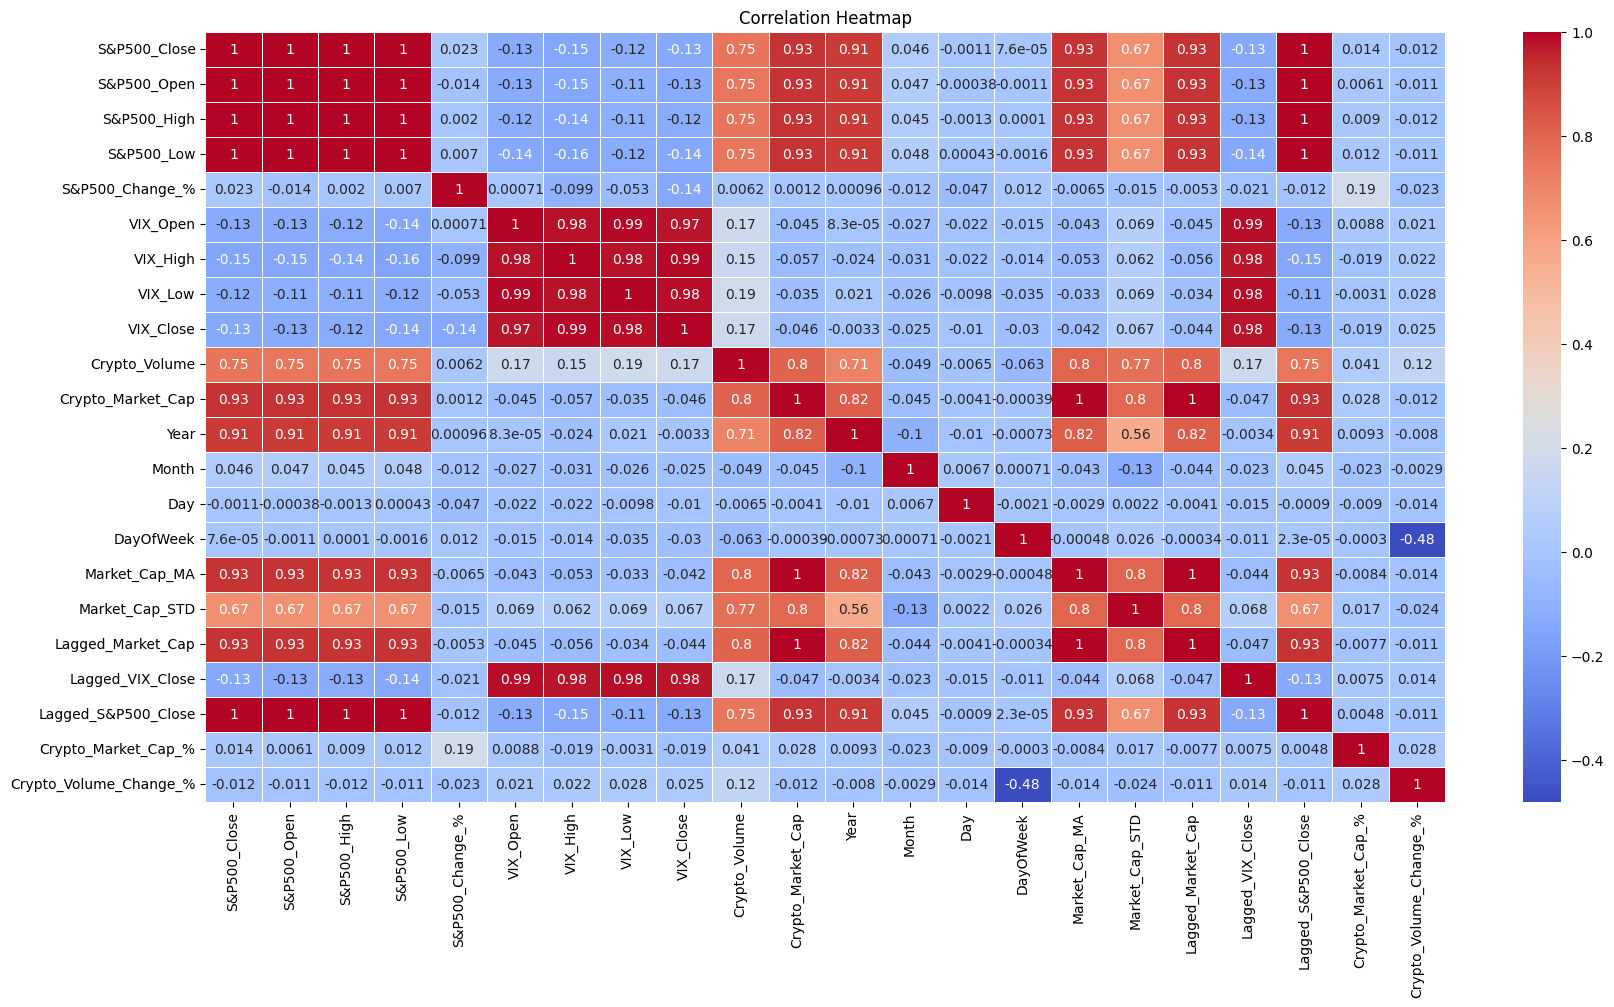

Crypto_Market_Cap         1.000000
Lagged_Market_Cap         0.999100
Market_Cap_MA             0.997783
S&P500_High               0.926930
S&P500_Open               0.926873
Lagged_S&P500_Close       0.926812
S&P500_Close              0.926792
S&P500_Low                0.926657
Year                      0.818587
Crypto_Volume             0.803887
Market_Cap_STD            0.796696
Crypto_Market_Cap_%       0.027632
S&P500_Change_%           0.001156
DayOfWeek                -0.000392
Day                      -0.004075
Crypto_Volume_Change_%   -0.012241
VIX_Low                  -0.035091
Month                    -0.045215
VIX_Open                 -0.045228
VIX_Close                -0.046046
Lagged_VIX_Close         -0.047276
VIX_High                 -0.057415
Name: Crypto_Market_Cap, dtype: float64

In [42]:
df_numeric = main_df.select_dtypes(include=['number'])

plt.figure(figsize=(20, 10))
sns.heatmap(df_numeric.corr("spearman"), linewidths=0.5, annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

df_numeric.corr("spearman")["Crypto_Market_Cap"].sort_values(ascending = False)

#### **Data Splitting**

Perfect, now we know that basically all of our features can help predict the crypto market cap!  
Let us prepare splitting the data and standardizing it to train our models by running the code below.

In [56]:
def split_time_series(df: pd.DataFrame, target_col: str, train_ratio: float) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.Series, pd.Series, pd.Series]:
    """
    Splits the time series dataset into train, validation, and test sets in a sequential manner.

    Args:
        df (pd.DataFrame): The input DataFrame (sorted by date).
        target_col (str): The name of the target column.
        train_ratio (float): The proportion of data to allocate for training (e.g., 0.8 means 80% for train, 10% for validation, 10% for test).

    Returns:
        tuple: DataFrames and Series for train, validation, and test sets (X_train, X_val, X_test, y_train, y_val, y_test).
    """
    # Ensure the data is sorted by time
    df = df.sort_values(by="Date")

    if not (0 < train_ratio < 1):
        raise ValueError("train_ratio must be between 0 and 1.")

    # Define split indices
    train_size = int(len(df) * train_ratio)
    val_size = int(len(df) * ((1 - train_ratio) / 2))

    # Sequential split
    train_data = df.iloc[:train_size]
    val_data = df.iloc[train_size:train_size + val_size]
    test_data = df.iloc[train_size + val_size:]

    # Extract features and target
    X_train, y_train = train_data.drop(columns=[target_col, "Date"]), train_data[target_col]
    X_val, y_val = val_data.drop(columns=[target_col, "Date"]), val_data[target_col]
    X_test, y_test = test_data.drop(columns=[target_col, "Date"]), test_data[target_col]

    return X_train, X_val, X_test, y_train, y_val, y_test


In [57]:
X_train, X_val, X_test, y_train, y_val, y_test = split_time_series(main_df, 'Crypto_Market_Cap', train_ratio=0.70)

feature_scaler = StandardScaler()
target_scaler = StandardScaler()

X_train = feature_scaler.fit_transform(X_train)
X_val = feature_scaler.transform(X_val)
X_test = feature_scaler.transform(X_test)

y_train = target_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_val = target_scaler.transform(y_val.values.reshape(-1, 1))
y_test = target_scaler.transform(y_test.values.reshape(-1, 1))

print("Train shapes:", X_train.shape, y_train.shape)
print("Validation shapes:", X_val.shape, y_val.shape)
print("Test shapes:", X_test.shape, y_test.shape)

Train shapes: (1839, 22) (1839, 1)
Validation shapes: (394, 22) (394, 1)
Test shapes: (395, 22) (395, 1)


### **Model Training**

These are a couple of helper functions, and variables that will help us asses our models!

In [58]:
TRAIN_SIZE = len(X_train)
VAL_SIZE = len(X_val)
TEST_SIZE = len(X_test)
TRAIN_INDICES = main_df.index[:TRAIN_SIZE]
VAL_INDICES = main_df.index[TRAIN_SIZE : TRAIN_SIZE + VAL_SIZE]
TEST_INDICES = main_df.index[TRAIN_SIZE + VAL_SIZE:]

def mean_directional_accuracy(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """
    Calculates Mean Directional Accuracy (MDA).
    
    Args:
        y_true (np.ndarray): Actual target values.
        y_pred (np.ndarray): Predicted target values.
    
    Returns:
        float: MDA score between 0 and 1.
    """
    return np.mean(np.sign(np.diff(y_true.flatten())) == np.sign(np.diff(y_pred.flatten())))

def evaluate_model(y_true: np.ndarray, y_pred: np.ndarray) -> dict[str, float]:
    """
    Evaluates the model on different metrics.
    
    Args:
        y_true (np.ndarray): Actual target values.
        y_pred (np.ndarray): Predicted target values.
    
    Returns:
        dict: Dictionary of metric names and their values.
    """

    return {
        "MSE": mean_squared_error(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "R²": r2_score(y_true, y_pred),
        "MDA": mean_directional_accuracy(y_true, y_pred)
    }

def print_evaluation_metric_results(results: dict[str, float], set: str) -> None:
    """
    Prints the evaluation results in a formatted and readable way.
    
    Args:
        results (dict): Evaluation results on a specific set.
        set (str): The name of the set (e.g., train, validation, test).
    """
    print("=" * 42)
    print(f"📊 Model Evaluation On {set} Set 📊")
    print("=" * 42)
    for metric, value in results.items():
        print(f"➡️ {metric}: {value:.4f}")
    print("=" * 42)

def plot_predictions(
    y_true: np.ndarray,
    y_pred: np.ndarray,
    indices: pd.Index,
    title: str
) -> None:
    """
    Plots true vs predicted values.
    
    Args:
        y_true (np.ndarray): Actual target values.
        y_pred (np.ndarray): Predicted target values.
        indices (pd.Index): Indices for the samples.
        title (str): Title of the plot.
    """
    plt.figure(figsize=(10, 4))
    plt.plot(indices, y_true, label='True Values', color='blue')
    plt.plot(indices, y_pred, label='Predicted Values', color='red', linestyle='--')
    plt.title(title)
    plt.xlabel('Samples')
    plt.ylabel('Scaled Market Cap')
    plt.legend()
    plt.show()

def plot_loss_curves(train_losses: list, val_losses: list) -> None:
    """
    Plots training and validation loss curves.
    
    Args:
        train_losses (list): List of training losses per epoch
        val_losses (list): List of validation losses per epoch
    """
    plt.figure(figsize=(10, 4))
    plt.plot(train_losses, label='Training Loss', color='blue')
    plt.plot(val_losses, label='Validation Loss', color='red')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Curves')
    plt.legend()
    plt.show()

Side note about metrics:
- **MSE/RMSE**: Values closer to 0 indicates higher accuracy.
- **R²**: A score closer to 1 is ideal, meaning the model fits the data well. A negative value indicates poor predictive performance.
- **MDA**: A score above 0.5 suggests better-than-random prediction, while a score close to 1 is ideal.  

Let us start first with a very simple model and see how it performs. Then we can go from there.

#### **Linear Regression**

📊 Model Evaluation On Training Set 📊
➡️ MSE: 0.0009
➡️ RMSE: 0.0308
➡️ R²: 0.9991
➡️ MDA: 0.7916
📊 Model Evaluation On Validation Set 📊
➡️ MSE: 0.0003
➡️ RMSE: 0.0183
➡️ R²: 0.9982
➡️ MDA: 0.7863
📊 Model Evaluation On Test Set 📊
➡️ MSE: 0.0037
➡️ RMSE: 0.0612
➡️ R²: 0.9935
➡️ MDA: 0.6904


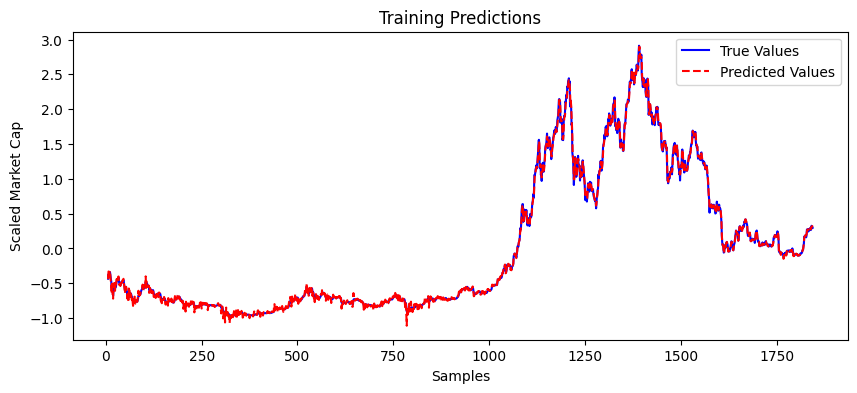

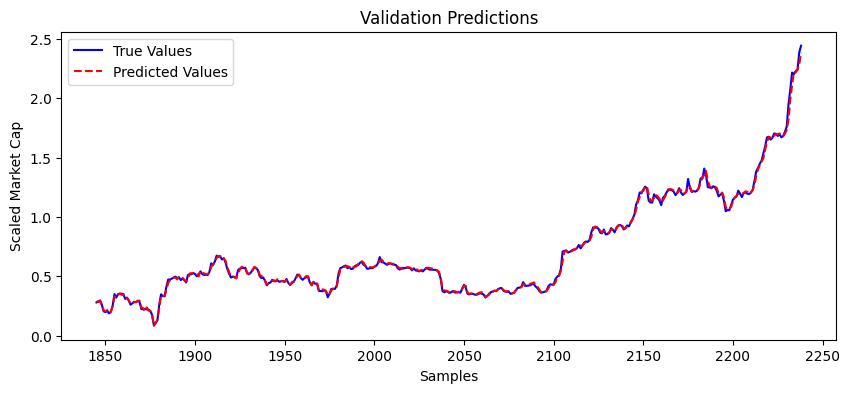

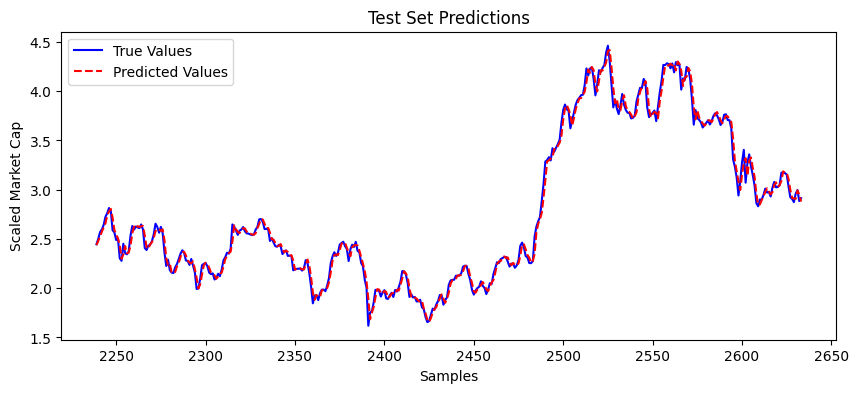

In [60]:
# Train model
lin_model = LinearRegression()
lin_model.fit(X_train, y_train)

# Make predictions
y_train_pred = lin_model.predict(X_train)
y_val_pred = lin_model.predict(X_val)
y_test_pred = lin_model.predict(X_test)

# Evaluate
train_results = evaluate_model(y_train, y_train_pred)
val_results = evaluate_model(y_val, y_val_pred)
test_results = evaluate_model(y_test, y_test_pred)

# Print metric results
print_evaluation_metric_results(train_results, 'Training')
print_evaluation_metric_results(val_results, 'Validation')
print_evaluation_metric_results(test_results, 'Test')

# Plot predictions
plot_predictions(y_train, y_train_pred, TRAIN_INDICES, "Training Predictions")
plot_predictions(y_val, y_val_pred, VAL_INDICES, "Validation Predictions")
plot_predictions(y_test, y_test_pred, TEST_INDICES, "Test Set Predictions")

#### **ANNs**

Let us move on to a more complex model: **ANNs**  
Run the cell below for some additional helper functions.

In [61]:
def train_model(
    model: nn.Module,
    criterion: nn.Module,
    optimizer: optim.Optimizer,
    X_train: torch.Tensor,
    y_train: torch.Tensor,
    X_val: torch.Tensor,
    y_val: torch.Tensor,
    epochs: int,
    print_every: int = 100
) -> tuple[list, list]:
    """Trains the model and returns loss histories."""
    train_losses, val_losses = [], []
    
    for epoch in range(epochs):
        # Training step
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        
        # Validation step
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val)
            val_loss = criterion(val_outputs, y_val)
        
        # Store losses
        train_losses.append(loss.item())
        val_losses.append(val_loss.item())
        
        if (epoch + 1) % print_every == 0:
            print(f"Epoch [{epoch+1}/{epochs}] ==> Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")
    
    return train_losses, val_losses

In [62]:
class ANNCryptoMarketCapPredictor(nn.Module):
    def __init__(self, input_size: int, output_size: int = 1):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, output_size)
        )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.model(x)

Epoch [100/500] ==> Train Loss: 0.0070, Val Loss: 0.0078
Epoch [200/500] ==> Train Loss: 0.0018, Val Loss: 0.0066
Epoch [300/500] ==> Train Loss: 0.0009, Val Loss: 0.0048
Epoch [400/500] ==> Train Loss: 0.0006, Val Loss: 0.0042
Epoch [500/500] ==> Train Loss: 0.0004, Val Loss: 0.0039
📊 Model Evaluation On Training Set 📊
➡️ MSE: 0.0004
➡️ RMSE: 0.0204
➡️ R²: 0.9996
➡️ MDA: 0.7367
📊 Model Evaluation On Validation Set 📊
➡️ MSE: 0.0039
➡️ RMSE: 0.0626
➡️ R²: 0.9786
➡️ MDA: 0.6641
📊 Model Evaluation On Test Set 📊
➡️ MSE: 0.0167
➡️ RMSE: 0.1291
➡️ R²: 0.9711
➡️ MDA: 0.8325


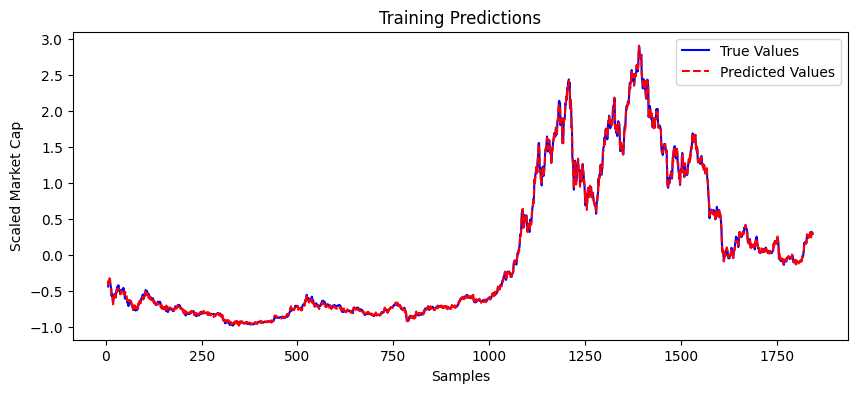

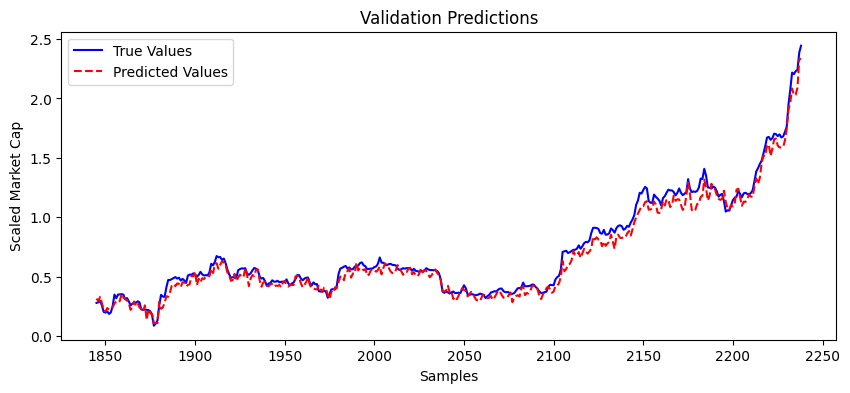

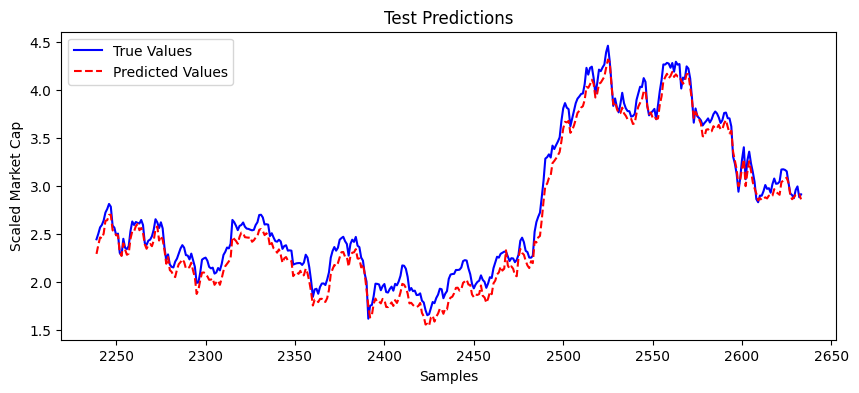

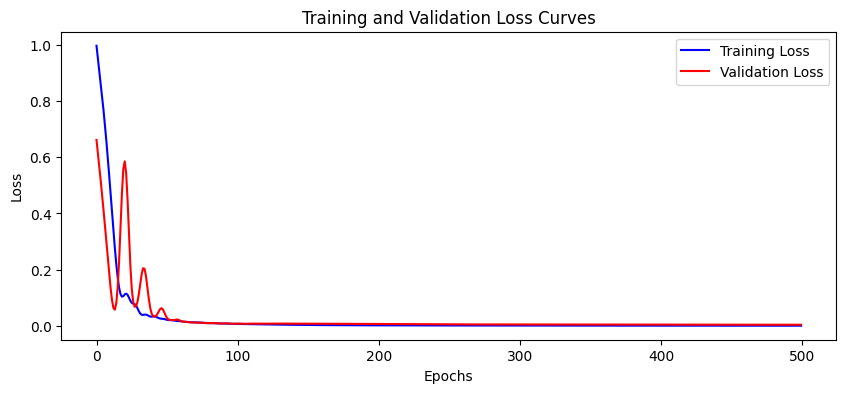

In [63]:
# Hyperparameters
input_size = X_train.shape[1]
lr = 0.001
epochs = 500

# Initialize model
model = ANNCryptoMarketCapPredictor(input_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# Convert data to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

train_losses, val_losses = train_model(
    model, criterion, optimizer,
    X_train_tensor, y_train_tensor,
    X_val_tensor, y_val_tensor,
    epochs
)

model.eval()
with torch.no_grad():
    train_pred = model(X_train_tensor)
    val_pred = model(X_val_tensor)
    test_pred = model(X_test_tensor)
    
    train_metrics = evaluate_model(y_train_tensor.detach().numpy(), train_pred)
    val_metrics = evaluate_model(y_val_tensor.detach().numpy(), val_pred)
    test_metrics = evaluate_model(y_test_tensor.detach().numpy(), test_pred)

# Print metric results
print_evaluation_metric_results(train_metrics, "Training")
print_evaluation_metric_results(val_metrics, "Validation")
print_evaluation_metric_results(test_metrics, "Test")

# Plot predictions and loss curves
plot_predictions(y_train, train_pred, TRAIN_INDICES, "Training Predictions")
plot_predictions(y_val, val_pred, VAL_INDICES, "Validation Predictions")
plot_predictions(y_test, test_pred, TEST_INDICES, "Test Predictions")
plot_loss_curves(train_losses, val_losses)